In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys, json
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = "/content/drive/MyDrive/AI_RL_Task_Scheduling"
DATA_DIR = f"{PROJECT_ROOT}/data"
SRC_DIR = f"{PROJECT_ROOT}/src"
OUTPUTS_DIR = f"{PROJECT_ROOT}/outputs"

sys.path.append(SRC_DIR)


Mounted at /content/drive


In [2]:
from sim_env import Task
from config import N_TRAIN_TASKS, N_EVAL_TASKS, SEEDS


In [3]:
def set_seed(seed: int):
    np.random.seed(seed)

def make_deadline(arrival_time: int, processing_time: int, slack_low: int, slack_high: int):
    slack = np.random.randint(slack_low, slack_high + 1)
    return arrival_time + processing_time + slack


In [4]:
def gen_uniform(n_tasks: int, seed: int):
    set_seed(seed)
    tasks = []
    t = 0
    for i in range(n_tasks):
        # inter-arrival: geometric-like (steady)
        t += np.random.geometric(p=0.3) - 1
        ptime = np.random.randint(1, 11)  # 1..10
        deadline = make_deadline(t, ptime, slack_low=10, slack_high=40)
        tasks.append(Task(i, t, ptime, deadline, remaining_time=ptime))
    return tasks

def gen_bursty(n_tasks: int, seed: int):
    set_seed(seed)
    tasks = []
    t = 0
    burst_every = 80
    for i in range(n_tasks):
        # create bursts periodically
        if i % burst_every == 0 and i > 0:
            # burst: many arrivals at same time window
            t += np.random.randint(0, 3)
            arrival = t
        else:
            t += np.random.geometric(p=0.5) - 1
            arrival = t

        ptime = np.random.randint(1, 13)  # 1..12
        deadline = make_deadline(arrival, ptime, slack_low=8, slack_high=30)
        tasks.append(Task(i, arrival, ptime, deadline, remaining_time=ptime))
    return tasks

def gen_heavy_tailed(n_tasks: int, seed: int):
    set_seed(seed)
    tasks = []
    t = 0
    for i in range(n_tasks):
        t += np.random.geometric(p=0.35) - 1
        # lognormal -> heavy-tail, clip to keep runtime bounded
        ptime = int(np.clip(np.random.lognormal(mean=1.2, sigma=0.7), 1, 50))
        deadline = make_deadline(t, ptime, slack_low=10, slack_high=50)
        tasks.append(Task(i, t, ptime, deadline, remaining_time=ptime))
    return tasks

def gen_deadline_constrained(n_tasks: int, seed: int):
    set_seed(seed)
    tasks = []
    t = 0
    for i in range(n_tasks):
        t += np.random.geometric(p=0.4) - 1
        ptime = np.random.randint(1, 11)  # 1..10
        # tight slack
        deadline = make_deadline(t, ptime, slack_low=3, slack_high=15)
        tasks.append(Task(i, t, ptime, deadline, remaining_time=ptime))
    return tasks


In [5]:
def save_tasks_jsonl(tasks, path):
    with open(path, "w") as f:
        for task in tasks:
            f.write(json.dumps({
                "task_id": task.task_id,
                "arrival_time": task.arrival_time,
                "processing_time": task.processing_time,
                "deadline": task.deadline
            }) + "\n")

def generate_and_save_all(n_tasks: int, tag: str):
    gens = {
        "uniform": gen_uniform,
        "bursty": gen_bursty,
        "heavy_tailed": gen_heavy_tailed,
        "deadline_constrained": gen_deadline_constrained
    }

    for wname, gen_fn in gens.items():
        for seed in SEEDS:
            tasks = gen_fn(n_tasks=n_tasks, seed=seed)
            out_path = f"{DATA_DIR}/{wname}_{tag}_seed{seed}.jsonl"
            save_tasks_jsonl(tasks, out_path)

    print(f"Saved workloads for {tag} (n_tasks={n_tasks}) to {DATA_DIR}")


In [6]:
generate_and_save_all(n_tasks=N_TRAIN_TASKS, tag="train")
generate_and_save_all(n_tasks=N_EVAL_TASKS, tag="eval")


Saved workloads for train (n_tasks=1000) to /content/drive/MyDrive/AI_RL_Task_Scheduling/data
Saved workloads for eval (n_tasks=2000) to /content/drive/MyDrive/AI_RL_Task_Scheduling/data


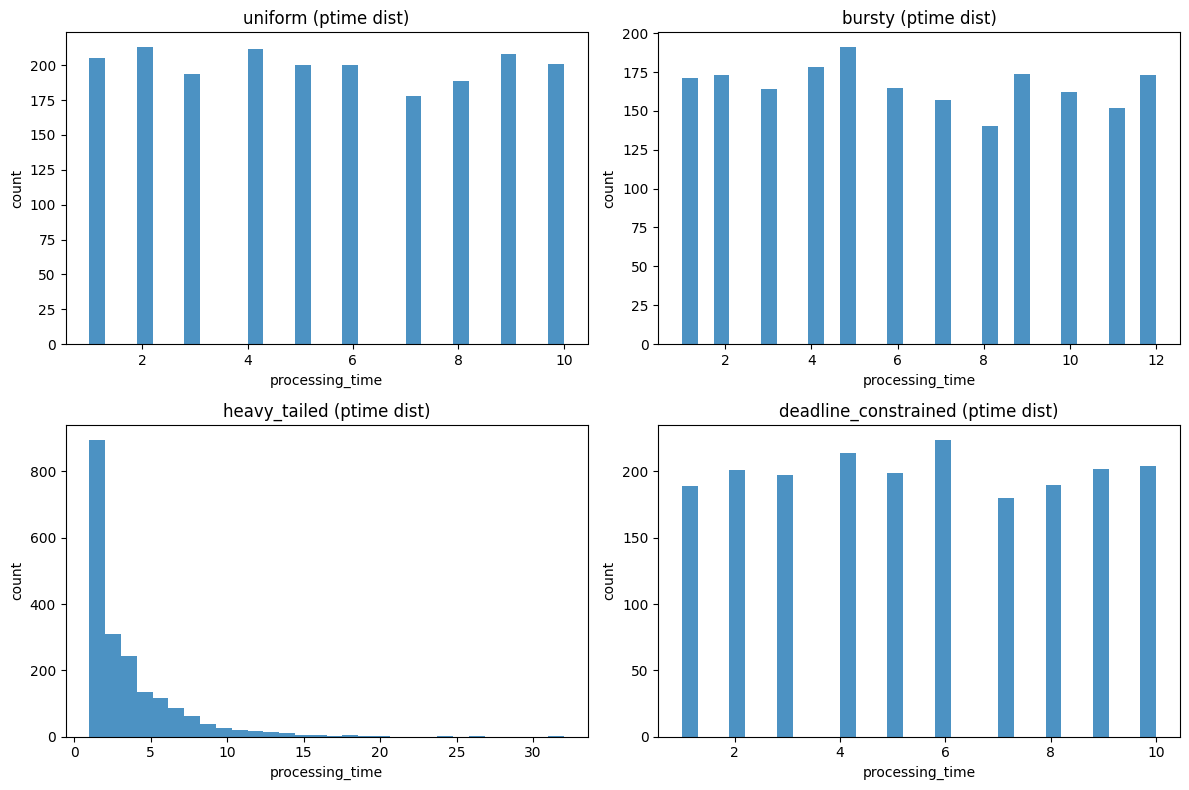

Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/workload_profiles_eval_seed0.png


In [7]:
def load_tasks_jsonl(path):
    tasks = []
    with open(path, "r") as f:
        for line in f:
            d = json.loads(line)
            tasks.append(d)
    return tasks

def plot_profiles(seed=0, tag="eval"):
    workload_names = ["uniform", "bursty", "heavy_tailed", "deadline_constrained"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for idx, wname in enumerate(workload_names):
        path = f"{DATA_DIR}/{wname}_{tag}_seed{seed}.jsonl"
        tasks = load_tasks_jsonl(path)

        arrivals = np.array([t["arrival_time"] for t in tasks])
        ptimes = np.array([t["processing_time"] for t in tasks])
        slacks = np.array([t["deadline"] - t["arrival_time"] - t["processing_time"] for t in tasks])

        ax = axes[idx]
        ax.hist(ptimes, bins=30, alpha=0.8)
        ax.set_title(f"{wname} (ptime dist)")
        ax.set_xlabel("processing_time")
        ax.set_ylabel("count")

    plt.tight_layout()
    out = f"{OUTPUTS_DIR}/workload_profiles_{tag}_seed{seed}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

plot_profiles(seed=0, tag="eval")


In [8]:
import pandas as pd

def dataset_summary(seed=0, tag="eval"):
    workload_names = ["uniform", "bursty", "heavy_tailed", "deadline_constrained"]
    rows = []
    for wname in workload_names:
        path = f"{DATA_DIR}/{wname}_{tag}_seed{seed}.jsonl"
        tasks = load_tasks_jsonl(path)
        arrivals = np.array([t["arrival_time"] for t in tasks])
        ptimes = np.array([t["processing_time"] for t in tasks])
        slacks = np.array([t["deadline"] - t["arrival_time"] - t["processing_time"] for t in tasks])

        rows.append({
            "workload": wname,
            "n_tasks": len(tasks),
            "arrival_span": int(arrivals.max() - arrivals.min()),
            "ptime_mean": float(ptimes.mean()),
            "ptime_max": int(ptimes.max()),
            "slack_mean": float(slacks.mean()),
            "slack_min": int(slacks.min()),
        })

    df = pd.DataFrame(rows)
    out_csv = f"{OUTPUTS_DIR}/dataset_summary_{tag}_seed{seed}.csv"
    df.to_csv(out_csv, index=False)
    return df, out_csv

df_sum, out_csv = dataset_summary(seed=0, tag="eval")
df_sum


,workload,n_tasks,arrival_span,ptime_mean,ptime_max,slack_mean,slack_min
0,uniform,2000,4864,5.4505,10,24.966,10
1,bursty,2000,1977,6.4095,12,18.943,8
2,heavy_tailed,2000,3674,3.7365,32,29.876,10
3,deadline_constrained,2000,3055,5.5075,10,8.999,3
